In [1]:
!pip install emoji -q
!pip install pymorphy2 -q
!python -m spacy download ru_core_news_sm -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 972.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 54.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import copy
from collections import defaultdict
import pathlib

import pandas as pd
import numpy as np
import torch
from torch import nn
import transformers
# from datasets import load_dataset, Features, Value, ClassLabel, LargeList, Sequence
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import emoji
from nltk.stem import SnowballStemmer
import pymorphy2
import spacy

In [4]:
# BACKBONE_NAME = 'cointegrated/rubert-tiny2'
BACKBONE_NAME = "DeepPavlov/rubert-base-cased"
# SUBMISSION_NAME = "rubert_tiny_classifier"
SUBMISSION_NAME = "rubert_base_cased"
NUM_LABELS = 50
BATCH_SIZE = 16
MAX_LEN = 256
RANDOM_STATE = 42
EPOCHS = 100
ROOT_DIR = pathlib.Path().absolute()

stemmer = SnowballStemmer(language="russian")
parser = spacy.load(
    'ru_core_news_sm',
    disable=["parser", "ner"],
)
tqdm.pandas()

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
df = pd.read_csv('train_augmented_2.csv')
df_test = pd.read_csv('test.csv')

df_test['text'] = df_test['text'].progress_apply(
    lambda x: emoji.demojize(str(x), language='ru').replace(':', ' ').replace('_', ' ')
)

  0%|          | 0/9015 [00:00<?, ?it/s]

In [7]:
df['text'] = df['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))

  0%|          | 0/7297 [00:00<?, ?it/s]

In [8]:
df_test['text'] = df_test['text'].progress_apply(lambda x: ' '.join([token.lemma_.lower() for token in parser(x)]))

  0%|          | 0/9015 [00:00<?, ?it/s]

In [8]:
df_test['text']

,text
0,"последний время думать плохо , срок доставка д..."
1,цена намного высоко магазинный но радовать акция
2,"доставка за [ num ] минута , заказ даже не нач..."
3,Ужасно долгий доставка
4,добрый вечер ! вы больший молодец . меня всё у...
...,...
9010,задержка с доставка не давать промокод на скид...
9011,очень удобный формат сервис и очень маленький ...
9012,"сумма заказ почти всегда высокий , что зачасту..."
9013,"Часто , заказывать у вас молочный продукция , ..."


In [9]:
df_train, df_valid = train_test_split(df, random_state=RANDOM_STATE, test_size=0.2, shuffle=True)

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list=None):
        self.tokenizer = tokenizer
        self.df = df.copy()
        self.text = df['text'].tolist()
        # self.text = df[['assessment', 'tags', 'text']].apply(lambda x: f"assessment: {x[0]}, tags: {x[1]}, text: {x[2]}", axis=1).tolist()
        # self.text = df[['tags', 'text']].apply(lambda x: f"tags: {x[0]}, text: {x[1]}", axis=1).tolist()
        self.targets = self.df[target_list].values if target_list else None
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        inputs = self.tokenizer.encode_plus(
            self.text[index],
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]) if self.targets is not None else torch.FloatTensor([]),
            'text': self.text[index]
        }

In [11]:
tokenizer = transformers.AutoTokenizer.from_pretrained(BACKBONE_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
full_dataset = CustomDataset(df, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
val_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, [f'trend_id_res{i}' for i in range(50)])
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [13]:
full_data_loader = torch.utils.data.DataLoader(
    full_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

train_data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

valid_data_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [14]:
class ClassificationModel(nn.Module):
    def __init__(self, base_transformer_model):
        super().__init__()
        self.backbone = transformers.AutoModel.from_pretrained(base_transformer_model, return_dict=True)
        clf_in_features = self.backbone.pooler.dense.out_features
        self.dropout = torch.nn.Dropout(0.1)
        self.linear = torch.nn.Linear(clf_in_features, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output = self.backbone(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

In [38]:
model = ClassificationModel(BACKBONE_NAME)

# # Freezing BERT layers: (tested, weaker convergence)
# for param in model.backbone.parameters():
#     param.requires_grad = False

model.to(device)

ClassificationModel(
  (backbone): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, el

In [39]:
criterion = torch.nn.BCEWithLogitsLoss()

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [15]:
def train(training_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    model.train()
    for batch in training_loader:
        # forward
        outputs = model(
            batch['input_ids'].to(device),
            batch['attention_mask'].to(device),
            batch['token_type_ids'].to(device)
        )
        loss = criterion(outputs, batch['targets'].to(device))
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = batch['targets'].cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        # grad descent step
        optimizer.step()

    # returning: trained model, model accuracy, mean loss
    return float(correct_predictions)/num_samples, np.mean(losses)

In [16]:
def evaluation(validation_loader, model, optimizer, criterion):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch in validation_loader:
            outputs = model(
                batch['input_ids'].to(device),
                batch['attention_mask'].to(device),
                batch['token_type_ids'].to(device)
            )

            loss = criterion(outputs, batch['targets'].to(device))
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = batch['targets'].cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)


In [41]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(train_data_loader, model, optimizer, criterion)
    val_acc, val_loss = evaluation(valid_data_loader, model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': model.state_dict()},
            f'gdrive/My Drive/ecom_tech_dls/{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

Epoch 1/100
train_loss=0.4136, val_loss=0.2308, train_acc=0.9259, val_acc=0.9662
Saving best model...
Epoch 2/100
train_loss=0.1862, val_loss=0.1591, train_acc=0.9669, val_acc=0.9662
Epoch 3/100
train_loss=0.1494, val_loss=0.1438, train_acc=0.9669, val_acc=0.9662
Epoch 4/100
train_loss=0.1401, val_loss=0.1392, train_acc=0.9669, val_acc=0.9662
Epoch 5/100
train_loss=0.1367, val_loss=0.1374, train_acc=0.9669, val_acc=0.9662
Epoch 6/100
train_loss=0.1355, val_loss=0.1367, train_acc=0.9669, val_acc=0.9662
Epoch 7/100
train_loss=0.1348, val_loss=0.1363, train_acc=0.9669, val_acc=0.9662
Epoch 8/100
train_loss=0.1342, val_loss=0.1352, train_acc=0.9669, val_acc=0.9662
Epoch 9/100
train_loss=0.1332, val_loss=0.1341, train_acc=0.9669, val_acc=0.9662
Epoch 10/100
train_loss=0.1320, val_loss=0.1329, train_acc=0.9669, val_acc=0.9662
Epoch 11/100
train_loss=0.1308, val_loss=0.1314, train_acc=0.9669, val_acc=0.9662
Epoch 12/100
train_loss=0.1287, val_loss=0.1286, train_acc=0.9670, val_acc=0.9664
Savi

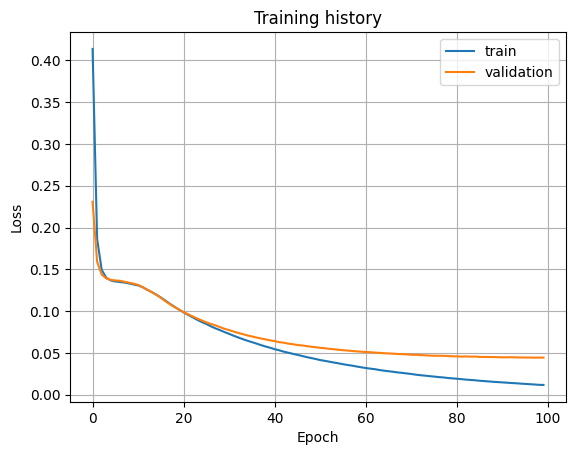

In [42]:
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='validation')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()

In [17]:
trained_model = ClassificationModel(BACKBONE_NAME)
trained_model = nn.DataParallel(trained_model)

checkpoint = torch.load(f'gdrive/My Drive/ecom_tech_dls/{SUBMISSION_NAME}.pt', map_location=device)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

trained_model.eval()

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-17-7e0ee9cb7fba>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the curr

DataParallel(
  (module): ClassificationModel(
    (backbone): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(119547, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, b

In [18]:
def write_submission(pred_test, test_df, name):
    answer = []
    np.apply_along_axis(
        lambda x: answer.append(' '.join(np.where(x == 1)[0].astype(str))),
        axis=1,
        arr=pred_test
    )
    test_df[["index"]].assign(target = answer).to_csv(ROOT_DIR / name, index=False)

In [20]:
batch = next(iter(test_data_loader))

In [21]:
out = trained_model(
    batch['input_ids'].to(device),
    batch['attention_mask'].to(device),
    batch['token_type_ids'].to(device)
)

In [39]:
torch.sigmoid(out).cpu().detach().numpy()[0]

array([1.3533779e-04, 4.7771904e-05, 7.5764896e-05, 1.6493093e-05,
       8.5681841e-06, 8.9774585e-06, 2.8505906e-06, 2.1185624e-06,
       2.5679332e-05, 3.2889027e-06, 1.1520134e-05, 2.3291064e-05,
       1.3862983e-05, 7.3456107e-07, 7.6625165e-06, 4.6721407e-06,
       4.1167856e-05, 3.0477125e-07, 1.2520834e-05, 5.4861134e-06,
       8.0901091e-06, 3.6988199e-06, 1.3463267e-06, 8.9845071e-06,
       7.2245035e-07, 7.9684838e-07, 4.5717475e-06, 1.1100392e-04,
       9.9966645e-01, 2.0815778e-05, 9.4435927e-06, 7.0657070e-06,
       2.4109718e-06, 6.6104599e-07, 1.3625926e-07, 4.5335710e-06,
       6.3961968e-05, 3.7738772e-07, 1.1793014e-06, 9.7094762e-06,
       2.1804078e-06, 1.1987619e-06, 7.9289975e-06, 1.6613496e-05,
       2.8658221e-06, 2.4466281e-06, 9.2176771e-07, 1.7113594e-05,
       1.3276842e-05, 2.2122365e-06], dtype=float32)

In [37]:
(torch.sigmoid(out).cpu().detach().numpy() > 0.9).astype(np.float32)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 

In [40]:
preds = None
for batch in tqdm(test_data_loader):
    out = trained_model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    # cur = (torch.sigmoid(out).cpu().detach().numpy() > 0.9).astype(np.float32)
    cur = torch.sigmoid(out).cpu().detach().numpy()
    if preds is not None:
        # preds = np.append(preds, torch.sigmoid(out).cpu().detach().numpy().round(), axis=0)
        preds = np.append(preds, cur, axis=0)
    else:
        preds = cur

  0%|          | 0/564 [00:00<?, ?it/s]

In [67]:
sum(preds > 0.6).astype(np.float32)

array([1449.,  719., 1178.,  560.,  210.,   97.,   26.,   45.,  272.,
          5.,  154.,  233., 1333.,   31.,  163.,  115.,  436.,    4.,
        364.,  549.,  253.,  162.,   37.,   96.,   11.,   10.,   38.,
       1131.,  945.,   54.,  623.,   49.,   19.,   61.,    3.,   77.,
        235.,   81.,   57.,   65.,  104.,   11.,   68.,   75.,   33.,
         17.,    4.,   42.,   48.,   11.], dtype=float32)

In [64]:
sum(preds.round())

array([1497.,  738., 1214.,  575.,  223.,  104.,   27.,   46.,  280.,
          5.,  164.,  239., 1344.,   38.,  173.,  119.,  455.,    5.,
        375.,  613.,  260.,  165.,   41.,  103.,   12.,   11.,   39.,
       1162.,  959.,   59.,  634.,   54.,   20.,   62.,    3.,   80.,
        245.,   87.,   60.,   68.,  113.,   12.,   73.,   78.,   40.,
         17.,    4.,   45.,   52.,   12.], dtype=float32)

In [62]:
preds[0][2]

True

In [60]:
preds

1.0

In [70]:
thresh = 0.57
write_submission((preds > thresh).astype(np.float32), df_test, f"{str(thresh).replace('.', '_')}_submission.csv")

In [24]:
res = pd.read_csv(f'{SUBMISSION_NAME}_submission.csv')

In [25]:
res

,index,target
0,3135,1 2 12
1,4655,12
2,22118,2 35
3,23511,0
4,45,18
...,...,...
9010,3523,37
9011,24925,12 22 23
9012,6327,8
9013,530,15


In [78]:
res[~res['target'].isna()]

,index,target
0,3135,1 2
1,4655,12
2,22118,2
3,23511,0
4,45,18 20
...,...,...
9010,3523,3 37
9011,24925,22
9012,6327,8
9013,530,15


In [ ]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    train_acc, train_loss = train(full_data_loader, model, optimizer, criterion)
    val_acc, val_loss = eval(valid_data_loader, model, optimizer, criterion)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        print('Saving best model...')
        torch.save(
            {'model_state_dict': model.state_dict()},
            f'gdrive/My Drive/ecom_tech_dls/full_{SUBMISSION_NAME}.pt',
        )
        best_accuracy = val_acc

Epoch 1/100
train_loss=0.2384, val_loss=0.1438, train_acc=0.9588, val_acc=0.9662
Saving best model...
Epoch 2/100
train_loss=0.1372, val_loss=0.1324, train_acc=0.9668, val_acc=0.9662
Epoch 3/100
train_loss=0.1252, val_loss=0.1158, train_acc=0.9671, val_acc=0.9679
Saving best model...
Epoch 4/100
train_loss=0.1097, val_loss=0.1000, train_acc=0.9694, val_acc=0.9711
Saving best model...
Epoch 5/100
train_loss=0.0954, val_loss=0.0861, train_acc=0.9731, val_acc=0.9746
Saving best model...
Epoch 6/100
train_loss=0.0832, val_loss=0.0736, train_acc=0.9765, val_acc=0.9802
Saving best model...
Epoch 7/100
train_loss=0.0716, val_loss=0.0629, train_acc=0.9800, val_acc=0.9836
Saving best model...
Epoch 8/100
train_loss=0.0617, val_loss=0.0542, train_acc=0.9831, val_acc=0.9876
Saving best model...
Epoch 9/100
train_loss=0.0531, val_loss=0.0460, train_acc=0.9860, val_acc=0.9894
Saving best model...
Epoch 10/100
train_loss=0.0455, val_loss=0.0389, train_acc=0.9884, val_acc=0.9904
Saving best model...


In [23]:
trained_model = ClassificationModel(BACKBONE_NAME)

checkpoint = torch.load(f'gdrive/My Drive/ecom_tech_dls/full_{SUBMISSION_NAME}.pt', map_location=device)
trained_model.load_state_dict(checkpoint['model_state_dict'])
trained_model.to(device)

trained_model.eval()

preds = None
for batch in tqdm(test_data_loader):
    out = trained_model(
        batch['input_ids'].to(device),
        batch['attention_mask'].to(device),
        batch['token_type_ids'].to(device)
    )
    if preds is not None:
        preds = np.append(preds, torch.sigmoid(out).cpu().detach().numpy().round(), axis=0)
    else:
        preds = torch.sigmoid(out).cpu().detach().numpy().round()

write_submission(preds, df_test, f'full_{SUBMISSION_NAME}_submission.csv')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-23-b0de45d39db8>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the curr

  0%|          | 0/564 [00:00<?, ?it/s]